In [13]:
# Import libs

import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [14]:
# Utility functions

def audio_to_stft(audio_file):
    data, sample_rate = librosa.load(audio_file, sr=44100)
    stft_data = np.abs(librosa.stft(data))
    return stft_data

In [44]:
# Collect STFT features and labels

stft_features = []
labels = []
n_frames = 250

for root, dirs, files in os.walk("new_heart_dataset"):
    for directory in dirs:
        label = os.path.basename(directory)
        category_dir = os.path.join(root, directory)
        for audio_file in os.listdir(category_dir):
            if audio_file.endswith('.wav'):
                labels.append(label)
                audio_path = os.path.join(category_dir, audio_file)
                stft_data = audio_to_stft(audio_path)
                stft_features.append(stft_data)


# Reshape STFT data
new_stft_features = []
for stft_data in stft_features:
    current_frames = stft_data.shape[1]

    if current_frames < n_frames:
        padded_data = np.pad(stft_data, ((0, 0), (0, n_frames - current_frames)), mode='constant')
        new_stft_features.append(padded_data)
    elif current_frames > n_frames:
        trimmed_data = stft_data[:, :n_frames]
        new_stft_features.append(trimmed_data)
    else:
        new_stft_features.append(stft_data)

new_stft_features = np.array(new_stft_features)


In [45]:
# Convert labels to categorical
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [46]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(new_stft_features, labels_categorical, test_size=0.2,
random_state=42)

In [47]:
# Update the number of classes in the output layer

num_classes = len(label_encoder.classes_)

# Define model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(1025, n_frames, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 1023, 248, 32)     320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 511, 124, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 509, 122, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 254, 61, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 252, 59, 64)       36928     
                                                                 
 flatten_4 (Flatten)         (None, 951552)           

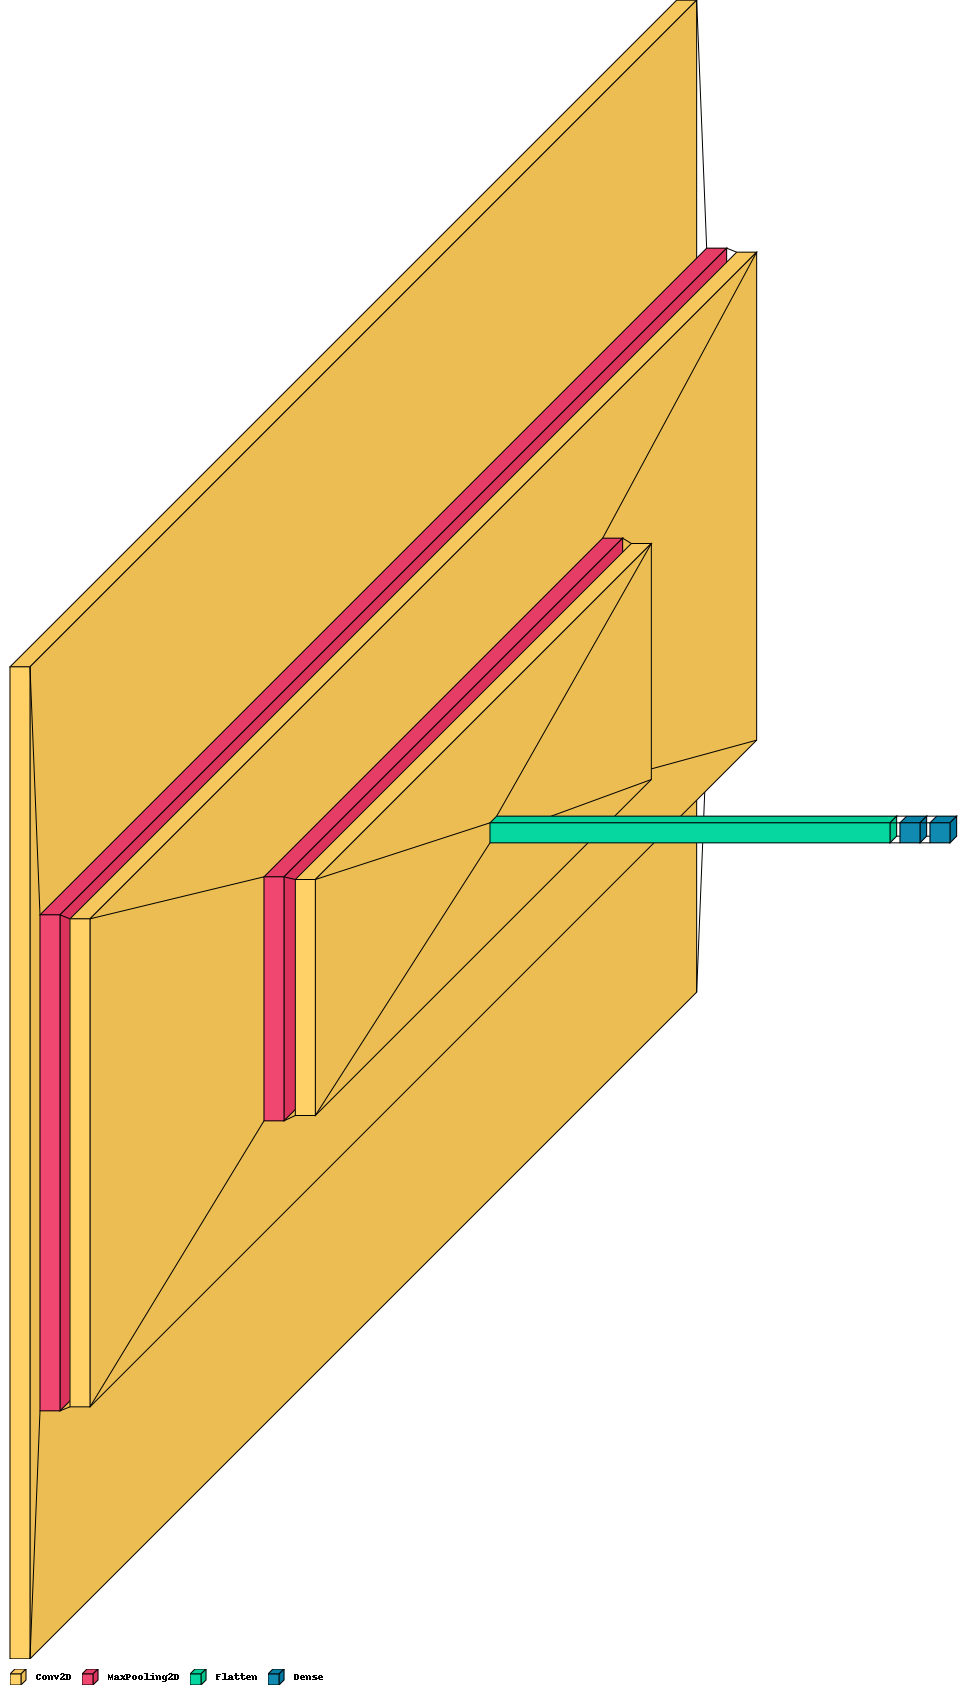

In [48]:
import visualkeras 

visualkeras.layered_view(model,to_file='output_model1.png',legend = True)

In [49]:
# Train the model
history = model.fit(
    np.array(X_train),
    np.array(Y_train),
    epochs=10, batch_size=32,
    validation_data=(np.array(X_test), np.array(Y_test))
    )

# Evaluate the model
loss, accuracy = model.evaluate(np.array(X_test), np.array(Y_test))
print("Test Accuracy:", accuracy * 100, "%")

Epoch 1/10
25/25 [==============================] - 1368s 57s/step - loss: 0.9913 - accuracy: 0.7962 - val_loss: 0.2007 - val_accuracy: 0.9350
Epoch 2/10
25/25 [==============================] - 160s 6s/step - loss: 0.0706 - accuracy: 0.9800 - val_loss: 0.0751 - val_accuracy: 0.9850
Epoch 3/10
25/25 [==============================] - 158s 6s/step - loss: 0.0249 - accuracy: 0.9950 - val_loss: 0.0674 - val_accuracy: 0.9950
Epoch 4/10
25/25 [==============================] - 145s 6s/step - loss: 0.0284 - accuracy: 0.9900 - val_loss: 0.1669 - val_accuracy: 0.9850
Epoch 5/10
25/25 [==============================] - 744s 31s/step - loss: 0.0377 - accuracy: 0.9887 - val_loss: 0.0915 - val_accuracy: 0.9750
Epoch 6/10
25/25 [==============================] - 185s 7s/step - loss: 0.0162 - accuracy: 0.9950 - val_loss: 0.0748 - val_accuracy: 0.9700
Epoch 7/10
25/25 [==============================] - 305s 12s/step - loss: 0.0428 - accuracy: 0.9825 - val_loss: 0.1253 - val_accuracy: 0.9800
Epoch 8/1

In [50]:
# Define Model 2
model2 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(1025, n_frames, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


model2.summary()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 1023, 248, 32)     320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 511, 124, 32)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_8 (Bat  (None, 511, 124, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 509, 122, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 254, 61, 64)       0         
 ng2D)                                                           
                                                      

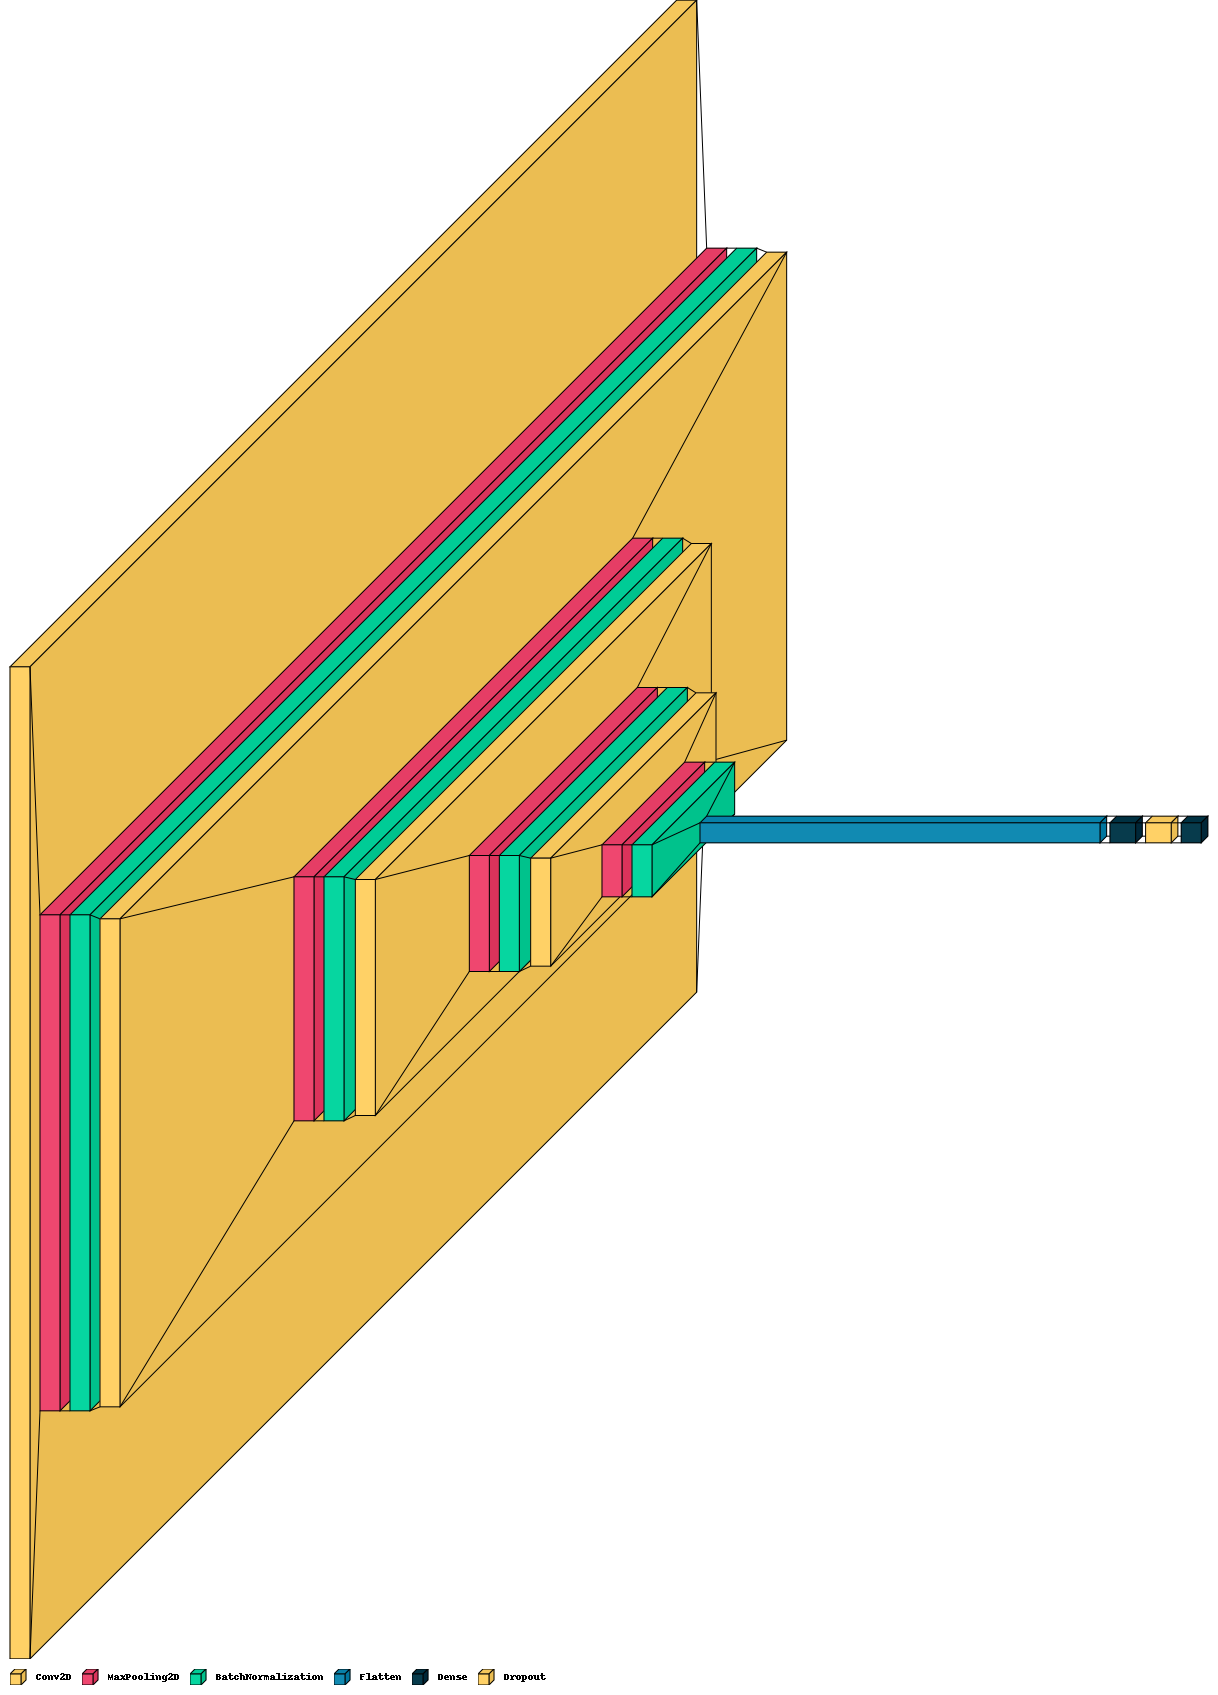

In [51]:
import visualkeras 

visualkeras.layered_view(model2,to_file='output_model2.png',legend = True)

In [ ]:
# Train Model 2
history2 = model2.fit(
    np.array(X_train),
    np.array(Y_train),
    epochs=10, batch_size=32,
    validation_data=(np.array(X_test), np.array(Y_test))
    )

# Evaluate Model 2
loss, accuracy = model2.evaluate(np.array(X_test), np.array(Y_test))
print("Test Accuracy:", accuracy * 100, "%")

Epoch 1/10
25/25 [==============================] - 583s 24s/step - loss: 8.7171 - accuracy: 0.5138 - val_loss: 2.2661 - val_accuracy: 0.4550
Epoch 2/10
 4/25 [===>..........................] - ETA: 12:20:16 - loss: 0.8006 - accuracy: 0.7266

In [ ]:
# Feature Extraction

# Extract
feat_extract = Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output
)

# Predict the features
feat_train = feat_extract.predict(X_train)
feat_test = feat_extract.predict(X_test)

# Model with different ensemble methods
ensemble_methods = {
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees Classifier": ExtraTreesClassifier(n_estimators=100, random_state=42)
}



# Model and predict using different ensemble methods
for method in ensemble_methods:
    print(f"Using {method}:")
    ensemble_methods[method].fit(feat_train, Y_train)
    
    method_predict = ensemble_methods[method].predict(feat_test)
    accuracy = accuracy_score(Y_test, method_predict)
    f1 = f1_score(Y_test, method_predict, average='weighted')
    print(f"Accuracy using {method} = {accuracy * 100}%")
    print(f"F1 score using {method} = {f1}")

In [ ]:
# Model using PCA

from sklearn.decomposition import PCA

test_accuracies = []
test_f1_scores = []
pca = PCA(n_components=10)
pca.fit(X_train_vgg_features)
feat_train_reduced = pca.transform(X_train_vgg_features)
feat_test_reduced = pca.transform(X_test_vgg_features)

for i in range(1, 16):
    test_accuracies = []
    test_f1_scores = []
    pca = PCA(n_components=i)
    pca.fit(X_train_vgg_features)
    feat_train_reduced = pca.transform(X_train_vgg_features)
    feat_test_reduced = pca.transform(X_test_vgg_features)
    for _ in range(5):
        rfc_pca = RandomForestClassifier(n_estimators=100, random_state=42)
        rfc_pca.fit(feat_train_reduced, Y_train)
        pca_predicted = rfc_pca.predict(feat_test_reduced)
        pca_acc = accuracy_score(Y_test, pca_predicted)
        pca_f1 = f1_score(Y_test, pca_predicted, average='weighted')
        test_accuracies.append(pca_acc)
        test_f1_scores.append(pca_f1)
    pca_mean_acc = np.mean(test_accuracies)
    pca_mean_f1 = np.mean(test_f1_scores)
    print(f"Mean Accuracy with PCA of n_components={i} = {pca_mean_acc * 100}%")
    print(f"Mean F1 score with PCA of n_components={i} = {pca_mean_f1}")
    print()